In [1]:
import cv2
import numpy as np

def detect_coastline(image_path, threshold=100):
    # 이미지 읽기
    image = cv2.imread(image_path)
    
    # 그레이스케일 변환
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Sobel 필터를 이용한 x, y 방향 에지 검출
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)  # x 방향 에지
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)  # y 방향 에지
    
    # 에지의 크기 계산 (모든 방향의 에지 강도)
    magnitude = cv2.magnitude(sobelx, sobely)
    
    # Threshold 적용
    _, coastline_mask = cv2.threshold(magnitude, threshold, 255, cv2.THRESH_BINARY)
    
    # Coastline 부분을 원본 이미지에 적용
    coastline_mask = coastline_mask.astype(np.uint8)
    coastline_result = cv2.bitwise_and(image, image, mask=coastline_mask)

    # coastline_mask = cv2.resize(coastline_mask, (1024, 1024))
    # coastline_result = cv2.resize(coastline_result, (1024, 1024))

    return coastline_mask, coastline_result

# 사용 예시
image_path = 'sample.png'
coastline_mask, coastline_result = detect_coastline(image_path)

cv2.imwrite('../coastline_mask.png', coastline_mask)
cv2.imwrite('../coastline_result.png', coastline_result)

# 결과 이미지 표시
# cv2.imshow('Coastline Mask', coastline_mask)
# cv2.imshow('Coastline Result', coastline_result)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


True

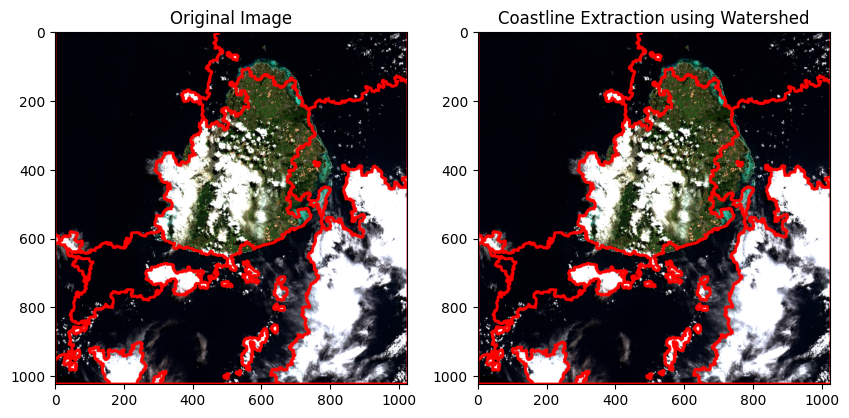

True

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def coastline_extraction_watershed(image_path, size=1024, blur_size=5, kernel_size=3):
    # 이미지 로드
    image = cv2.imread(image_path)
    # size = 1024
    image = cv2.resize(image, (size, size))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 노이즈 제거를 위한 Gaussian Blur 적용
    blurred = cv2.GaussianBlur(gray, (blur_size, blur_size), 0)
    
    # Otsu's Binarization을 사용한 이진화 처리
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Morphological Transformations를 사용하여 전경과 배경 구분
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    sure_bg = cv2.dilate(binary, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.2 * dist_transform.max(), 255, 0)
    
    # 전경과 배경의 불확실한 부분을 찾기
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # 레이블링을 통한 마커 생성
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    # Watershed 알고리즘 적용
    markers = cv2.watershed(image, markers)
    image[markers == -1] = [0, 0, 255]  # 경계를 빨간색으로 표시

    # 두꺼운 경계선을 위해 dilate 연산 적용
    boundary_mask = (markers == -1).astype(np.uint8)  # 경계선만 있는 마스크 생성
    dilated_boundary = cv2.dilate(boundary_mask, kernel, iterations=3)  # 두께 조정 가능 (iterations 수 변경)
    
    # 원본 이미지에 두꺼운 경계선을 적용
    image[dilated_boundary == 1] = [0, 0, 255]  # 빨간색으로 두꺼운 경계선 표시

    # 결과 이미지 시각화
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    plt.subplot(1, 2, 2)
    plt.title("Coastline Extraction using Watershed")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

    return image

# 사용 예시
image_path = 'sample.png'
size = 1024
blur_size = 19
kernel_size = 3
result = coastline_extraction_watershed(image_path, size, blur_size, kernel_size)
cv2.imwrite('../watershed_coastline_result.png', result)
